The advance model is built on 

In [65]:
import json
import math
import os
import random
from copy import deepcopy
from datetime import datetime
from time import time

import torch
from bert_score import score
from PIL import Image, ImageDraw, ImageFont, ImageStat
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torcheval.metrics import Perplexity
from torchtext.data import get_tokenizer
from torchtext.data.metrics import bleu_score
from torchtext.vocab import GloVe
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm

# Import class Cider_Scorer from pycocoevalcap/cider/cider_scorer.py file
from pycocoevalcap.cider.cider_scorer import CiderScorer
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from BARTScore.bart_score import BARTScorer

In [66]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [67]:
# To print the values in bold or in different colors
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [68]:
# Define constants for training
cwd = os.getcwd()
DATA_DIR = cwd + '/data-processed'
IMAGES_DIR = os.path.join(DATA_DIR, 'memes')
CAPTIONS_PATH = os.path.join(DATA_DIR, 'cleaned_english_captions_v1.json')

# Initialize tokenizer
tokenizer = get_tokenizer("basic_english")

## Text Embeddings

This is where we define the text embedding model to use. Here we are building our embedding model from the approach provided here

https://www.kaggle.com/code/ratthachat/flickr-image-captioning-tpu-tf2-glove?scriptVersionId=34452283

In [69]:
# Special tokens for the caption (they exist in the GloVe vocabulary)
SPECIAL_TOKENS = {
    'UNK': '<u>',
    'PAD': '<p>',
    'EOS': '<s>',
}
EMBEDDING_DIMENSIONS = 50
VOCABULARY_PATH = os.path.join(DATA_DIR, 'vocabulary.json')
VECTORS_PATH = os.path.join(DATA_DIR, f'vectors{EMBEDDING_DIMENSIONS}.pt')
MAX_CAPTION_LENGTH = 50 # Maximum number of words in a caption

In [70]:
# Generate the vocabulary from all captions we have

if os.path.exists(VOCABULARY_PATH):
    # If file already exists read from it
    with open(VOCABULARY_PATH, "r") as f:
        vocabulary = json.load(f)
else:
    # Generate the vocabulary from all captions we have
    
    vocabulary = set(SPECIAL_TOKENS.values())

    with open(CAPTIONS_PATH, "r") as f:
        data = json.load(f)
        for image_name in data:
            for caption in data[image_name]:
                vocabulary.update(tokenizer(caption))
                
    vocabulary = list(vocabulary)

    # Write the vocabulary to a file
    with open(VOCABULARY_PATH, "w") as f:
        json.dump(vocabulary, f)
        
print('Vocabulary size', len(vocabulary))

Vocabulary size 84880


### Create the embeddings from the GloVe

In [71]:
# Generate embedding matrix for the vocabulary
def build_matrix(vocabulary):

    """
    Create an embedding matrix for the memes vocabulary from the GloVe embeddings.
    """
    
    # Load GloVe Embeddings
    vector_embeddings = GloVe(name="twitter.27B", dim=EMBEDDING_DIMENSIONS)    

    # Initialize the embedding matrix with random tensors taken from a uniform distribution
    # with provided mean and std
    emb_mean, emb_std = -0.0033470048, 0.109855264

    # torch.normal--> Returns a tensor of random numbers drawn from separate normal distributions
    # whose mean and standard deviation are given.
    matrix = torch.normal(mean=emb_mean, std=emb_std, size=(len(vocabulary), EMBEDDING_DIMENSIONS))

    print("Generating embeddings")
    
    # The for loop will update the embedding matrix for the tokens found in the GloVe vocabulary with
    # the corresponding embedding vectors in GloVe
    for i, word in tqdm(list(enumerate(vocabulary))):
        # Look up embedding vectors of tokens. Our tokens are already in the lowercase
        # so we do not require to use parameter 'lower_case_backup'
        matrix[i] = vector_embeddings.get_vecs_by_tokens(word)

    return matrix

In [72]:
# nn.embedding is a sparse layer. It is a lookup table that stores embeddings of a fixed dictionary and size.
# This module is often used to store word embeddings and retrieve them using indices.
embedding = nn.Embedding(len(vocabulary), EMBEDDING_DIMENSIONS)

# We do not want to train the embeddings (as we are using the GloVe embeddings)
embedding.weight.requires_grad = False

# stoi is a dictionary that returns the index of a word in the embeddings vocabulary
embedding.stoi = {word: i for i, word in enumerate(vocabulary)}

#itos is a dictionary that returns the word given the index
embedding.itos = {i: word for i, word in enumerate(vocabulary)}

if os.path.exists(VECTORS_PATH):
    embedding.weight.data = torch.load(VECTORS_PATH)
else:
    # Build the embedding matrix
    embedding.weight.data = build_matrix(vocabulary)
    # Save the embeddings of our captions to file
    torch.save(embedding.weight.data, VECTORS_PATH)

## Data Loader

Create a Dataset and the Data Loader

In [73]:
# Constants
TEST_SIZE = 0.2
BATCH_SIZE=15 # Came up with this batch size considering the model architecture and the GPU memory

# This variable is created when required to train the model on few images
# to check if the code is working
IMAGES_LIMIT = -1

In [74]:
class MemeDataset(Dataset):
    def __init__(self, images_path, captions_path, image_names, embedding):
        """
        Initializes a MemeDataset object.

        Args:
            images_path (str): The path to the directory containing the images.
            captions_path (str): The path to the file containing the captions.
            image_names (list): A list of image names to load.
            embedding : To read the indices of the captions vocabulary
        """

        self.images_path = images_path
        self.captions_path = captions_path
        self.image_names = image_names
        self.images = {}
        self.captions = []
        self.embedding = embedding
        
        self._load_dataset()

    def _load_dataset(self):

        # Check if the images directory exist
        assert os.path.exists(
            self.images_path
        ), f"Images directory {self.images_path} is not found"

        # Check if the prepared captions (after preprocessing) file exist
        assert os.path.exists(
            self.captions_path
        ), f"Captions file {self.captions_path} is not found"

        # load the meme images
        for image_name in self.image_names:
            image_path = os.path.join(self.images_path, image_name)
            assert os.path.exists(image_path), f"Image file {image_path} is not found"
            # Open the image and apply pre-processing
            self.images[image_name] = self._preprocess_image(Image.open(image_path))

        # load the memes
        with open(self.captions_path, "r") as f:
            data = json.load(f)
            for image_name in self.image_names:
                for caption in data[image_name]:
                    # Store a tuple of image name and caption (in form of tokens)
                    self.captions.append((image_name, self._preprocess_text(caption)))

    def _preprocess_text(self, text):
        # tokenize
        tokens = tokenizer(text)

        # replace with `UNK`
        tokens = [
            tok if tok in self.embedding.stoi else SPECIAL_TOKENS["UNK"] for tok in tokens
        ]

        # Truncate the caption if length > MAX_CAPTION_LENGTH
        if len(tokens) > MAX_CAPTION_LENGTH:
            tokens = tokens[:MAX_CAPTION_LENGTH]

        # add `EOS`
        tokens += [SPECIAL_TOKENS["EOS"]]

        # convert to ids
        tokens = [self.embedding.stoi[token] for token in tokens]

        # casts the tensor to a torch.int64 data type to ensure int64 data type
        return torch.tensor(tokens).long() 

    def _preprocess_image(self, image):
        # Ref:- https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
        # https://pytorch.org/hub/pytorch_vision_resnet/
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(), # this will convert the image to (C x H x W)
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        return preprocess(image)

    def __getitem__(self, idx):
        # Get the name of the image and it's associated meme
        image_name, caption = self.captions[idx]
        # Get the preprocessed image
        image = self.images[image_name]
        
        return image_name, image, caption, torch.tensor(caption.shape[0])

    def __len__(self):
        return len(self.captions)

In [75]:
with open(CAPTIONS_PATH, "r") as f:
    data = json.load(f)
    # all_images will have the name of all the images
    all_images = list(data.keys())

# Limit the images to shorten dataset
if IMAGES_LIMIT != -1:
    all_images = all_images[:IMAGES_LIMIT]

train_images, test_images = train_test_split(all_images, test_size=TEST_SIZE,random_state=42)

# Create train & test datasets
train_dataset = MemeDataset(
    images_path=IMAGES_DIR, 
    captions_path=CAPTIONS_PATH,
    image_names=train_images,
    embedding=embedding,
)

test_dataset = MemeDataset(
    images_path=IMAGES_DIR,
    captions_path=CAPTIONS_PATH,
    image_names=test_images,
    embedding=embedding,
)

# Print the size of the datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 282838
Test dataset size: 70190


In [76]:
# Memory pinning for faster loading to GPU https://pytorch.org/docs/stable/data.html#memory-pinning

# As the batch preparation is custom and to enable memory pinning for custom batch, define a pin_memory() method on the custom type(s).
class MemeDatasetBatch():
    def __init__(self, image_names, images, captions, caption_lengths):
        self.image_names = image_names
        self.images = images
        self.captions = captions
        self.caption_lengths = caption_lengths
    
    def pin_memory(self):
        self.images = self.images.pin_memory()
        self.captions = self.captions.pin_memory()
        return self

def pad_collate(batch):
    """Batch collate with padding for Dataloader."""
    # unpack batch - zip returns an iterator of tuples, where length of tuple would be the batch size     
    image_names, images, captions, caption_lengths = zip(*batch)           

    # torch.stack : This will convert the tuple of tensors to a tensor
    images = torch.stack(images, dim=0)    

    caption_lengths = torch.stack(caption_lengths, dim=0)    

    # pad captions (Pad a list of variable length Tensors with padding_value) --> will convert tuple of tensors to a tensor
    captions = pad_sequence(captions, batch_first=True, padding_value=embedding.stoi[SPECIAL_TOKENS["PAD"]])    

    return MemeDatasetBatch(image_names, images, captions, caption_lengths)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=pad_collate,
    # Host to GPU copies are much faster when they originate from pinned (page-locked) memory
    pin_memory=True,
    pin_memory_device=device.type,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=pad_collate,
    pin_memory=True,
    pin_memory_device=device.type
)

sample = next(iter(train_dataloader))
print(f'Images shape: {sample.images.shape}, pinned: {sample.images.is_pinned()}, device: {sample.images.device}')
print(f'Captions shape: {sample.captions.shape}, pinned: {sample.captions.is_pinned()}, device: {sample.captions.device}')

Images shape: torch.Size([15, 3, 224, 224]), pinned: True, device: cpu
Captions shape: torch.Size([15, 25]), pinned: True, device: cpu


In [77]:
# Check one of the caption prepared by the dataset in the batch
tokens = [embedding.itos[index.item()] for index in sample.captions[6]]
print(tokens)

['if', 'your', 'life', 'is', 'pathetic', 'here', 'is', 'a', 'sign', 'with', 'bulshit', 'on', 'it', 'to', 'make', 'you', 'fel', 'beter', 'about', 'yourself', '<s>', '<p>', '<p>', '<p>', '<p>']


## Image Encoder

This is the image encoding layer. The output of this layer must be same as the caption embedding dimension

In [78]:
class ImageEncoder(nn.Module):
    def __init__(self, output_size=256, dropout=0.2):
        """Initializes ImageEncoder.

        Args:
            output_size (int): dimensions of the output embedding
            dropout (float): dropout for the encoded features
        """

        super(ImageEncoder, self).__init__()

        self.output_size = output_size

        # Use the pre-trained weights of the ResNet50 model
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Set the parameters of the ResNet50 model to not require gradients
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.linear = nn.Linear(in_features=self.resnet.fc.out_features, out_features=output_size)

        # Batch Normalization (https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
        self.batch_normalization = nn.BatchNorm1d(output_size)

        self.dropout = nn.Dropout(p=dropout)

    def train(self, mode):
        super().train(mode)

        # Keep resnet always in eval mode
        self.resnet.eval()

    def forward(self, images):
        """
        Encodes input images into a global image embedding.

        Args:
            images (torch.Tensor): input images of shape `[batch size, channel, width, height]`

        Returns:
            torch.Tensor: global image embedding of shape `[batch size, emb_dim]`
        """

        features = self.resnet(images)

        img_embedding = self.dropout(self.batch_normalization(self.linear(features)))

        return img_embedding


image_encoder = ImageEncoder()
image_encoder.eval()
image_encoder.to(device)
# Evaluating the image encoding on the sample created
image_encoder(sample.images.to(device))

tensor([[ 1.5601e-01, -3.6051e-01,  2.6073e-02,  ...,  1.0700e-01,
          4.5082e-01,  1.4810e-01],
        [-8.1298e-02, -8.1060e-02, -8.4606e-02,  ...,  2.1893e-01,
          8.7856e-02, -7.9705e-02],
        [-4.7569e-01, -6.8359e-02, -4.8612e-01,  ..., -2.6531e-01,
         -2.4951e-01,  1.2493e-01],
        ...,
        [-3.9261e-04, -2.4074e-01,  6.3979e-02,  ...,  1.2140e-01,
          3.5728e-01,  3.3123e-01],
        [-3.7722e-01,  2.1024e-01, -3.1651e-01,  ..., -1.1145e-01,
          1.4203e-01,  4.3252e-01],
        [ 5.4147e-01, -2.5595e-01,  5.4352e-01,  ...,  8.8798e-01,
         -3.6170e-01,  1.6225e-01]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)

In [79]:
sample.caption_lengths

tensor([25,  8, 12, 11,  7, 19, 21, 15, 11, 13,  9, 16,  8, 15, 10])

## LSTM Decoder

This is the LSTM Decoder with the Beam Search Helper 

In [80]:
class BeamSearchHelper:
    """Helper class with common functions for beam search sampling."""

    def __init__(
        self,
        temperature,
        beam_width,
        top_k,
        unk_index,
        eos_index,
        device="cuda"
    ):
        assert beam_width <= top_k, "`beam_width` should be less than `top_k`"

        self.temperature = temperature
        self.beam_width = beam_width
        self.top_k = top_k
        self.unk_index = unk_index
        self.eos_index = eos_index
        self.device = device
        self._build_has_ended_variables()

    def _build_has_ended_variables(self):
        """
        Returns flags and masks for monitoring if generation has ended.
        """
        # flags showing if text sequence has ended --> Create a tensor of size beam_width with all values as False
        self.has_ended = torch.tensor([False] * self.beam_width).to(self.device)

        # masks for filtering out predictions for ended/not_ended sequences
        self._n_copies_has_ended = torch.tensor([[self.beam_width], [1]]).to(self.device)
        self._mask_has_ended = torch.stack(
            [
                torch.tensor([True] * self.beam_width),
                torch.tensor([True] + [False] * (self.beam_width - 1)),
            ],
            dim=0,
        ).to(self.device)

    def filter_top_k(self, logits):
        """Filters `top_k` logit values by zeroing out others."""
        
        # torch.topk will return the tuple of values and indices for top k elements of logits.
        # We want the smallest value out of the top k elements. Use this value to compare
        # with the values of output tokens, and put True at the indexes where it is smaller    
        filter_ind = logits < torch.topk(logits, self.top_k, dim=-1).values[:, -1].unsqueeze(-1)
        # Also put the True value at the index of UNK token, as we do not want to have UNK
        # token in our output
        filter_ind[:, self.unk_index] = True  
        # Put -inf at the indexes where the filter_ind is True
        logits[filter_ind] = float("-inf")        
        return logits

    def sample_k_indices(self, logits, k=None):
        """Samples `beam_width` indices for each sequence in the batch."""        
        
        # compute probabilities
        p_next = torch.softmax(logits / self.temperature, dim=-1)       
        
        # if the value of k is None, then take the beam_width value as k
        k = self.beam_width if k is None else k
        # Get the indices sampled from the multinomial probability distribution
        # located in the corresponding row of tensor input
        sample_ind = torch.multinomial(input=p_next, num_samples=k, replacement=False)

        return sample_ind

    @staticmethod
    def filter_by_indices(values, indices):
        # Collect the logits values corresponding to the indices
        sample_val = torch.gather(input=values, dim=1, index=indices)
        return sample_val

    def process_logits(self, logits, sample_seq, sample_val):
        """Main logic of beam search sampling step.

        Steps:
            - filter `top_k` logit scores
            - filter out predictions for already ended sequences
            - check if new predictions end sequence
            - update `has_ended` indices

        Args:
            logits (torch.Tensor): logit predictions, outputs of the classifier layer
            sample_seq (torch.Tensor): `beam_width` sequences from the previous sampling step
            sample_val (torch.Tensor): scores for the sequences from the previous sampling step

        Returns:
            (prev_seqs, prev_vals), (new_ind, new_val):
                expanded sequences and their scores from the previous sampling step
                + new candidate predictions and their scores
        """
        
        # filter `top_k` values
        logits = self.filter_top_k(logits)

        # sample `beam` sequences for each branch
        # get the top 10 indexes of the highest probability token 
        new_ind = self.sample_k_indices(logits, k=self.beam_width)
        new_val = self.filter_by_indices(logits, new_ind).log_softmax(-1)
        
        new_ind, new_val = new_ind.flatten(), new_val.flatten()        

        # numbers of repeat_interleave copies (if ended, only a single copy)
        n_copies = self._n_copies_has_ended[self.has_ended.long(), :].flatten()       

        # mask for unique rows
        unique_rows = self._mask_has_ended[self.has_ended.long(), :].flatten()
        
        # filter values
        new_ind = new_ind[unique_rows]
        new_val = new_val[unique_rows]

        # check if the sequences already ended
        # (no need to predict and evaluate new scores)
        self.has_ended = torch.repeat_interleave(self.has_ended, n_copies, dim=0)
        
        new_ind[self.has_ended], new_val[self.has_ended] = 0, 0.0

        # update `had_ended` based on new predictions
        self.has_ended = self.has_ended | (new_ind == self.eos_index)

        # repeat current sampled sequences
        prev_seqs = torch.repeat_interleave(sample_seq, n_copies, dim=0)
        prev_vals = torch.repeat_interleave(sample_val, n_copies, dim=0)

        if len(prev_seqs.size()) == 1:
            prev_seqs = prev_seqs.unsqueeze(0)
            prev_vals = prev_vals.unsqueeze(0)

        return (prev_seqs, prev_vals), (new_ind, new_val)

    def all_ended(self):
        """Returns bool indicating if all sequences have ended."""
        return torch.all(self.has_ended)

In [81]:
class LSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.1):
        super(LSTMDecoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=(0 if num_layers == 1 else dropout),
        )

        self.classifier = nn.Linear(hidden_size, output_size)        

    def forward(self, image_embeddings, caption_embeddings, caption_lengths):
        """
        This method will return the output of shape (batch_size, max_caption_length, output_size)
        max_caption_length is the maximum length of the caption in the batch
        """
        
        # image embedding + caption embeddings (packed so that they can be sent to LSTM at once)
        # Start with image embedding as the first time-step input
        x = torch.cat((image_embeddings.unsqueeze(1), caption_embeddings), dim=1)

        # Pack the captions embeddings to avoid training on the padded tokens
        packed = pack_padded_sequence(
            x, caption_lengths, batch_first=True, enforce_sorted=False
        )

        outputs, _ = self.lstm(packed)
        # Return the outputs with the padding
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)        

        # mapping into token space
        outputs = self.classifier(outputs)

        return outputs
    
    # The embedding here is the embedding instance because we are not keeping it in this class, but we need it for the generation
    def generate(self, image_embedding, embedding, max_len, temperature, beam_width, top_k, eos_index):
        # beam search sampling helper
        helper = BeamSearchHelper(
            temperature=temperature,
            beam_width=beam_width,
            top_k=top_k,
            unk_index=embedding.stoi[SPECIAL_TOKENS["UNK"]],
            eos_index=eos_index,
            device='cpu'
        )

        # run LSTM over the inputs and predict the next token
        outputs, (h, c) = self.lstm(image_embedding)        
        
        # As the start to the generation of the tokens we only have the image embedding, so resulting
        # logits would be of shape torch.Size([1, 84880])
        logits = self.classifier(outputs[:, -1, :])       
        
        # repeat hidden state  and cell state `beam` times
        # The hidden state and cell state will be of dimension (num_layers, batch_size, hidden_size)
        # Repeat the hidden state for each layer to the beam_width times. 
        h, c = h.repeat((1, beam_width, 1)), c.repeat((1, beam_width, 1))        

        # filter `top_k` values
        logits = helper.filter_top_k(logits)       
        
        # compute probabilities and sample k values
        sample_ind = helper.sample_k_indices(logits, k=beam_width)  
        # Apply the log softmax to the filtered out values. The log softmax is applied to
        # avoid the numerical underflow problem      
        sample_val = helper.filter_by_indices(logits, sample_ind).log_softmax(-1)
        
        sample_ind, sample_val = sample_ind.T, sample_val.T
       
        # define total prediction sequences
        sample_seq = sample_ind.clone().detach()

        # reusable parameters
        beam_copies = torch.tensor([beam_width] * beam_width).to(outputs.device)
        
        # update `has_ended` index
        # contiguous is used to ensure resulting tensor is stored in contiguous block of memory,
        # as for view to reshape it requires tensor to be stored in contiguously

        helper.has_ended = (sample_ind == eos_index).contiguous().view(-1)    
        # print("helper.has_ended", helper.has_ended)    
     
        for i in range(sample_seq.size(1), max_len):
            # predict the next time step
            # Get the embedding of the predicted tokens from the previous time-step
            inputs = embedding(sample_ind)
            
            # Everytime it will have 10 hidden states, as for each time step we are predicting 10 tokens
            outputs, (h, c) = self.lstm(inputs, (h, c))
            
            # logits would be of shape torch.Size([10, 84880]) because we want to predict tokens = beam_width
            logits = self.classifier(outputs[:, -1, :])            

            (prev_seqs, prev_vals), (new_ind, new_val) = helper.process_logits(
                logits, sample_seq, sample_val
            )

            # create candidate sequences and compute their probabilities
            cand_seq = torch.cat((prev_seqs, new_ind.unsqueeze(0).T), -1)
            cand_val = prev_vals.flatten() + new_val

            # sample `beam` sequences
            filter_ind = helper.sample_k_indices(cand_val, k=beam_width)

            # update total sequences and their scores
            sample_val = cand_val[filter_ind]
            sample_seq = cand_seq[filter_ind]
            sample_ind = sample_seq[:, -1].unsqueeze(-1)

            # filter `has_ended` flags
            helper.has_ended = helper.has_ended[filter_ind]

            # check if every branch has ended
            if helper.all_ended():
                break

            # repeat hidden state `beam` times and filter by sampled indices
            h = torch.repeat_interleave(h, beam_copies, dim=1)
            c = torch.repeat_interleave(c, beam_copies, dim=1)

            h, c = h[:, filter_ind, :], c[:, filter_ind, :]
           
        # sample output sequence
        ind = helper.sample_k_indices(sample_val, k=2)
        output_seq = sample_seq[ind, :].squeeze()

        return output_seq

## Meme Generation LSTM Model

In [82]:
class MemeGenerationLSTM(nn.Module):
    """LSTM-based image captioning model.

    Encodes input images into a embeddings of size `emb_dim`
    and passes them as the first token to the caption generation decoder.
    """

    def __init__(self, embedding, hidden_size, num_layers, encoder_dropout, decoder_dropout):
        super(MemeGenerationLSTM, self).__init__()

        # We need to keep them same for LSTM because the first
        # input to the LSTM is the image embedding and rest is caption
        # embedding
        self.embedding = embedding
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder_dropout = encoder_dropout
        self.decoder_dropout = decoder_dropout

        # Initialize the Encoder which is the Image Encoder (ResNet50 model)
        self.encoder = ImageEncoder(
            output_size=self.embedding.embedding_dim,# Embedding dimension of the Image which is 50 defined in variable EMBEDDING_DIMENSIONS
            dropout=self.encoder_dropout,
        )
        
        self.decoder = LSTMDecoder(
            input_size=self.embedding.embedding_dim, # Embedding dimension of the Image which is 50 defined in variable EMBEDDING_DIMENSIONS
            hidden_size=self.hidden_size,
            output_size=self.embedding.num_embeddings,# Number of tokens in the vocabulary including the special tokens
            num_layers=self.num_layers,
            dropout=self.decoder_dropout,
        )

        self.params = {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'encoder_dropout': encoder_dropout,
            'decoder_dropout': decoder_dropout,
        }

    def forward(self, images, captions, caption_lengths):
        
        # Retrieve Image Embeddings for the processed batch
        image_embeddings = self.encoder(images)
        # Retrieve Caption Embeddings for the processed batch
        caption_embeddings = self.embedding(captions)
        # Get the outputs from the decoder
        output = self.decoder(image_embeddings, caption_embeddings, caption_lengths)

        return output

    def generate(self, image, max_len, temperature, beam_width, top_k):
        """Generates caption for an image.

        Args:
            image (torch.Tensor): input image of shape `[1, width, height]`
            caption (torch.Tensor, optional): beginning tokens of the caption of shape `[1, seq_len]`
            max_len (int): maximum length of the caption
            temperature (float): temperature for softmax over logits
            beam_width (int): number of maintained branches at each step
            top_k (int): number of the most probable tokens to consider during sampling
      
        Returns:
            torch.Tensor: generated caption tokens of shape `[1, min(output_len, max_len)]`
        """

        # get image embedding
        image_embedding = self.encoder(image).unsqueeze(1)

        sampled_ids = self.decoder.generate(
            image_embedding,
            embedding=self.embedding,
            max_len=max_len,
            temperature=temperature,
            beam_width=beam_width,
            top_k=top_k,
            eos_index=self.embedding.stoi[SPECIAL_TOKENS["EOS"]],
        )

        return sampled_ids

    def save(self, ckpt_path):
        """Saves the model's state and hyperparameters."""
        torch.save({"model": self.state_dict(), "params": self.params}, ckpt_path)

    @staticmethod
    def from_pretrained(ckpt_path):
        """Loads and builds the model from the checkpoint file."""
        ckpt = torch.load(ckpt_path, map_location="cpu")
        params = ckpt["params"]

        model = MemeGenerationLSTM(
            embedding=embedding,
            hidden_size=params["hidden_size"],
            num_layers=params["num_layers"],
            encoder_dropout=params["encoder_dropout"],
            decoder_dropout=params["decoder_dropout"],
        )
        model.load_state_dict(ckpt["model"])

        return model

In [83]:
HIDDEN_SIZE = 256
NUM_LAYERS = 2
ENCODER_DROPOUT = 0.2
DECODER_DROPOUT = 0.1

# Create model instance
model = MemeGenerationLSTM(
    embedding=embedding,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    encoder_dropout=ENCODER_DROPOUT,
    decoder_dropout=DECODER_DROPOUT,
).to(device)

# Just checking the output shape of the model on the sample data
output = model.eval()(sample.images.to(device), sample.captions.to(device), sample.caption_lengths)
output.shape

torch.Size([15, 25, 84880])

## Model Training

In [84]:
class Trainer:
    """A final class for running the models."""

    def __init__(self, experiment_title, log_dir="./logs1", checkpoint_dir="./checkpoints", phases=("train", "val"), device="cpu"):
        self.experiment_data = self._setup_experiment(experiment_title, log_dir, checkpoint_dir)

        self.phases = phases
        self.device = device

        self.writers = self._setup_writers()

    @staticmethod
    def _setup_experiment(title, log_dir, checkpoint_dir):
        experiment_name = "{}@{}".format(title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
        experiment_dir = os.path.join(log_dir, experiment_name)
        best_model_path = f"{title}.best.pth"

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        experiment_data = {
            "model_name": title,
            "name": experiment_name,
            "dir": experiment_dir,
            "checkpoint_dir": checkpoint_dir,
            "best_model_path": best_model_path,
            "epochs": 0,
            "iterations": 0,
        }

        return experiment_data

    def _setup_writers(self):
        return {phase: SummaryWriter(log_dir=os.path.join(self.experiment_data["dir"], phase)) for phase in self.phases}

    def run_epoch(self, model, dataloader, optimizer, criterion_main, criterion_aux, phase="train"):
        # Boolean variable to check if the model is in training mode
        is_train = phase == "train"

        # Set the model to train mode if it is in training phase otherwise in evaluation mode
        model.train() if is_train else model.eval()

        epoch = self.experiment_data["epochs"] # this epoch will be the epoch set in train_model method
        iterations = self.experiment_data["iterations"]
        # Initialize the epoch loss and epoch perplexity to 0
        epoch_loss, epoch_pp = 0.0, 0.0

        # On Training we want to enable the gradients
        with torch.set_grad_enabled(is_train):
            tqdm_object = tqdm(dataloader, desc=f"{phase} ({epoch})")

            for batch in tqdm_object: # Iterations Loop (number of iterations to complete one epoch over complete training/evaluation data)
                # max_len <-- maximum length of the caption in the batch
                batch_size, max_len = batch.captions.size()                
                images = batch.images.to(self.device)
                captions = batch.captions.to(self.device)
                caption_lengths = batch.caption_lengths                

                # Call the forward method of the MemeGenerationLSTM class
                pred = model(images, captions, caption_lengths)                

                # Trim if there are more than max_len tokens of the processed batch
                pred = pred[:, :max_len, :]
                
                # mask will have value True for all the tokens that are not PAD tokens
                mask = captions != embedding.stoi[SPECIAL_TOKENS["PAD"]]

                # The calculation of both the CrossEntropyLoss and Perplexity requires the unnormlized probabilities
                # of the predictions.
                # Before applying the mask, the shape of the pred will be (batch_size, max_len, vocab_size).
                # After applying mask, the shape of the pred will be (sum of number of non PAD tokens in the batch which can be
                # calculated as sum of caption_lengths, vocab_size). In other words, the batch_size, max_len dimensions will be
                # flattened to a single dimension.
                # Cross Entropy Loss requires 2D data, which is the reason to apply mask
                loss = criterion_main(pred[mask], captions[mask])
                # The calculation of perplexity requires input to be of shape (batch_size, seq_len, vocab_size)
                # and target to be of shape (batch_size, seq_len).
                pp = criterion_aux.update(pred, captions).compute()

                if is_train:
                    # make optimization step
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                if is_train:
                    iterations += 1                
                 
                epoch_loss += loss.item() * batch_size # de-average the loss as later it is being averaged over the entire dataset
                epoch_pp += pp.item() * batch_size # de-average the perplexity

                # dump batch metrics to tensorboard
                if self.writers is not None and phase in self.writers and is_train:
                    self.writers[phase].add_scalar(f"train/batch_loss", loss.item(), iterations)
                    self.writers[phase].add_scalar(f"train/batch_perplexity", pp.item(), iterations)

                tqdm_object.set_postfix(loss=loss.item(), perplexity=pp.item())

            epoch_loss = epoch_loss / len(dataloader.dataset)
            epoch_pp = epoch_pp / len(dataloader.dataset)

            # dump epoch metrics to tensorboard
            if self.writers is not None and phase in self.writers:
                self.writers[phase].add_scalar(f"eval/loss", epoch_loss, epoch)
                self.writers[phase].add_scalar(f"eval/perplexity", epoch_pp, epoch)

        if is_train:
            self.experiment_data["iterations"] = iterations

        return epoch_loss, epoch_pp

    def train_model(self, model, dataloaders, optimizer, criterion_main, criterion_aux, scheduler=None, n_epochs=10):
        # Initialize the best epoch and best validation loss
        best_epoch, best_val_loss = 0, float("+inf")

        # This would be useful to resume training from a checkpoint
        past_epochs = self.experiment_data["epochs"]       

        if self.writers is None:
            self._setup_writers()

        for epoch in range(past_epochs + 1, past_epochs + n_epochs + 1): # Epoch Loop
            self.experiment_data["epochs"] = epoch # Set the current epoch in the experiment data
            print(f"Epoch {epoch:02d}/{past_epochs + n_epochs:02d}")

            st = time()
            for phase in self.phases:                
                epoch_loss, epoch_pp = self.run_epoch(
                    model, dataloaders[phase], optimizer, criterion_main, criterion_aux, phase=phase
                )

                print(f"  {phase:5s} loss: {epoch_loss:.5f}, perplexity: {epoch_pp:.3f}")
                # Print the learning rate
                for i, param_group in enumerate(optimizer.param_groups):
                    print(f"Learning rate for group {i}: {param_group['lr']}")

                # If during the validation, the training loss is less than the best validation loss,
                # then save the model
                if phase == "val" and epoch_loss < best_val_loss:
                    best_epoch, best_val_loss = epoch, epoch_loss
                    # Save the best model
                    model.save(os.path.join(self.experiment_data['checkpoint_dir'], self.experiment_data["best_model_path"]))

                # Sae the model after every epoch
                model.save(os.path.join(self.experiment_data['checkpoint_dir'], f"{self.experiment_data['model_name']}.e{epoch}.pth"))

                if phase == "val" and scheduler is not None:
                    # Learning rate scheduling should be applied after optimizer’s update
                    # https://discuss.pytorch.org/t/reduce-lr-on-plateau-based-on-training-loss-or-validation/183344
                    scheduler.step(epoch_loss)

            et = time() - st
            print(f"  epoch time: {et:.2f}s")            

        print(f"Best val_loss: {best_val_loss} (epoch: {best_epoch})")

        self.experiment_data["epochs"] = epoch # Set the last epoch value
        

        return self.experiment_data

    def close(self):
        for writer in self.writers.values():
            writer.close()
        self.writers = None

In [86]:
# Define constants for training
EPOCHS = 20
LOGS_DIR = "./logs_resnet"
CHECKPOINTS_DIR = "./checkpoints_resnet"
TITLE = 'MemeGenerationResnet'
LEARNING_RATE = 5e-4

In [87]:
# Train the model
trainer = Trainer(TITLE, log_dir=LOGS_DIR, checkpoint_dir=CHECKPOINTS_DIR, device=device)

# Create model instance
model = MemeGenerationLSTM(
    embedding=embedding,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    encoder_dropout=ENCODER_DROPOUT,
    decoder_dropout=DECODER_DROPOUT,
).to(device)

# Training helpers
criterion_main = nn.CrossEntropyLoss(ignore_index=embedding.stoi[SPECIAL_TOKENS["PAD"]]).to(device)
criterion_aux = Perplexity(ignore_index=embedding.stoi[SPECIAL_TOKENS["PAD"]]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=1, factor=0.7
    )

trainer.train_model(
    model=model,
    dataloaders={"train": train_dataloader, "val": test_dataloader},
    optimizer=optimizer,
    criterion_main=criterion_main,
    criterion_aux=criterion_aux,
    n_epochs=EPOCHS,
    scheduler=scheduler
)

Epoch 01/20


train (1): 100%|██████████| 18856/18856 [17:01<00:00, 18.46it/s, loss=5.02, perplexity=365]   


  train loss: 5.90495, perplexity: 739.430
Learning rate for group 0: 0.0005


val (1): 100%|██████████| 4680/4680 [02:48<00:00, 27.72it/s, loss=5.27, perplexity=341]


  val   loss: 5.60040, perplexity: 353.385
Learning rate for group 0: 0.0005
  epoch time: 1192.10s
Epoch 02/20


train (2): 100%|██████████| 18856/18856 [16:28<00:00, 19.07it/s, loss=4.35, perplexity=262]


  train loss: 5.24252, perplexity: 293.785
Learning rate for group 0: 0.0005


val (2): 100%|██████████| 4680/4680 [03:02<00:00, 25.60it/s, loss=5.15, perplexity=257]


  val   loss: 5.44183, perplexity: 259.920
Learning rate for group 0: 0.0005
  epoch time: 1173.73s
Epoch 03/20


train (3): 100%|██████████| 18856/18856 [16:46<00:00, 18.73it/s, loss=5.26, perplexity=220]


  train loss: 5.01317, perplexity: 235.914
Learning rate for group 0: 0.0005


val (3): 100%|██████████| 4680/4680 [02:49<00:00, 27.65it/s, loss=5.03, perplexity=220]


  val   loss: 5.40311, perplexity: 220.218
Learning rate for group 0: 0.0005
  epoch time: 1177.92s
Epoch 04/20


train (4): 100%|██████████| 18856/18856 [16:29<00:00, 19.06it/s, loss=5.4, perplexity=197] 


  train loss: 4.87211, perplexity: 206.552
Learning rate for group 0: 0.0005


val (4): 100%|██████████| 4680/4680 [02:49<00:00, 27.67it/s, loss=4.99, perplexity=197]


  val   loss: 5.39662, perplexity: 197.084
Learning rate for group 0: 0.0005
  epoch time: 1160.50s
Epoch 05/20


train (5): 100%|██████████| 18856/18856 [16:27<00:00, 19.09it/s, loss=4.66, perplexity=181]


  train loss: 4.77022, perplexity: 188.021
Learning rate for group 0: 0.0005


val (5): 100%|██████████| 4680/4680 [02:49<00:00, 27.66it/s, loss=5.01, perplexity=182]


  val   loss: 5.39933, perplexity: 181.501
Learning rate for group 0: 0.0005
  epoch time: 1157.98s
Epoch 06/20


train (6): 100%|██████████| 18856/18856 [16:26<00:00, 19.11it/s, loss=4.82, perplexity=169]


  train loss: 4.69581, perplexity: 174.933
Learning rate for group 0: 0.0005


val (6): 100%|██████████| 4680/4680 [02:49<00:00, 27.66it/s, loss=4.99, perplexity=171]


  val   loss: 5.41746, perplexity: 170.204
Learning rate for group 0: 0.0005
  epoch time: 1157.25s
Epoch 07/20


train (7): 100%|██████████| 18856/18856 [16:30<00:00, 19.05it/s, loss=4.32, perplexity=160]


  train loss: 4.59936, perplexity: 164.872
Learning rate for group 0: 0.00035


val (7): 100%|██████████| 4680/4680 [02:49<00:00, 27.65it/s, loss=5.04, perplexity=161]


  val   loss: 5.42949, perplexity: 160.853
Learning rate for group 0: 0.00035
  epoch time: 1160.64s
Epoch 08/20


train (8): 100%|██████████| 18856/18856 [16:30<00:00, 19.04it/s, loss=4.9, perplexity=153] 


  train loss: 4.55898, perplexity: 156.751
Learning rate for group 0: 0.00035


val (8): 100%|██████████| 4680/4680 [02:49<00:00, 27.67it/s, loss=5.15, perplexity=154]


  val   loss: 5.43341, perplexity: 153.617
Learning rate for group 0: 0.00035
  epoch time: 1160.74s
Epoch 09/20


train (9): 100%|██████████| 18856/18856 [16:30<00:00, 19.05it/s, loss=3.83, perplexity=147]


  train loss: 4.49591, perplexity: 150.128
Learning rate for group 0: 0.000245


val (9): 100%|██████████| 4680/4680 [02:49<00:00, 27.68it/s, loss=5.06, perplexity=148]


  val   loss: 5.44178, perplexity: 147.406
Learning rate for group 0: 0.000245
  epoch time: 1160.42s
Epoch 10/20


train (10): 100%|██████████| 18856/18856 [16:29<00:00, 19.05it/s, loss=4.5, perplexity=142] 


  train loss: 4.47379, perplexity: 144.592
Learning rate for group 0: 0.000245


val (10): 100%|██████████| 4680/4680 [02:48<00:00, 27.71it/s, loss=5.08, perplexity=143]


  val   loss: 5.45118, perplexity: 142.407
Learning rate for group 0: 0.000245
  epoch time: 1159.80s
Epoch 11/20


train (11): 100%|██████████| 18856/18856 [16:29<00:00, 19.06it/s, loss=5.01, perplexity=137]


  train loss: 4.43161, perplexity: 139.993
Learning rate for group 0: 0.0001715


val (11): 100%|██████████| 4680/4680 [02:49<00:00, 27.64it/s, loss=5.02, perplexity=139]


  val   loss: 5.45049, perplexity: 138.030
Learning rate for group 0: 0.0001715
  epoch time: 1159.44s
Epoch 12/20


train (12): 100%|██████████| 18856/18856 [16:29<00:00, 19.05it/s, loss=5.08, perplexity=134]


  train loss: 4.42113, perplexity: 136.004
Learning rate for group 0: 0.0001715


val (12): 100%|██████████| 4680/4680 [02:49<00:00, 27.63it/s, loss=5.07, perplexity=135]


  val   loss: 5.46247, perplexity: 134.407
Learning rate for group 0: 0.0001715
  epoch time: 1160.10s
Epoch 13/20


train (13): 100%|██████████| 18856/18856 [16:30<00:00, 19.05it/s, loss=4.04, perplexity=131]


  train loss: 4.39001, perplexity: 132.631
Learning rate for group 0: 0.00012004999999999999


val (13): 100%|██████████| 4680/4680 [02:49<00:00, 27.59it/s, loss=5.04, perplexity=132]


  val   loss: 5.46266, perplexity: 131.182
Learning rate for group 0: 0.00012004999999999999
  epoch time: 1160.55s
Epoch 14/20


train (14): 100%|██████████| 18856/18856 [16:29<00:00, 19.05it/s, loss=3.92, perplexity=128]


  train loss: 4.38108, perplexity: 129.664
Learning rate for group 0: 0.00012004999999999999


val (14): 100%|██████████| 4680/4680 [02:49<00:00, 27.63it/s, loss=5.13, perplexity=129]


  val   loss: 5.47061, perplexity: 128.423
Learning rate for group 0: 0.00012004999999999999
  epoch time: 1160.27s
Epoch 15/20


train (15): 100%|██████████| 18856/18856 [16:28<00:00, 19.07it/s, loss=3.88, perplexity=125]


  train loss: 4.35553, perplexity: 127.057
Learning rate for group 0: 8.403499999999999e-05


val (15): 100%|██████████| 4680/4680 [02:49<00:00, 27.66it/s, loss=5.1, perplexity=126] 


  val   loss: 5.47248, perplexity: 125.919
Learning rate for group 0: 8.403499999999999e-05
  epoch time: 1158.89s
Epoch 16/20


train (16): 100%|██████████| 18856/18856 [16:28<00:00, 19.07it/s, loss=5.4, perplexity=123] 


  train loss: 4.35014, perplexity: 124.723
Learning rate for group 0: 8.403499999999999e-05


val (16): 100%|██████████| 4680/4680 [02:49<00:00, 27.63it/s, loss=5.09, perplexity=124]


  val   loss: 5.47738, perplexity: 123.737
Learning rate for group 0: 8.403499999999999e-05
  epoch time: 1159.06s
Epoch 17/20


train (17): 100%|██████████| 18856/18856 [16:28<00:00, 19.08it/s, loss=4.31, perplexity=121]


  train loss: 4.33188, perplexity: 122.665
Learning rate for group 0: 5.882449999999999e-05


val (17): 100%|██████████| 4680/4680 [02:49<00:00, 27.63it/s, loss=5.12, perplexity=122]


  val   loss: 5.47962, perplexity: 121.747
Learning rate for group 0: 5.882449999999999e-05
  epoch time: 1158.51s
Epoch 18/20


train (18): 100%|██████████| 18856/18856 [16:28<00:00, 19.07it/s, loss=4.02, perplexity=120]


  train loss: 4.32838, perplexity: 120.792
Learning rate for group 0: 5.882449999999999e-05


val (18): 100%|██████████| 4680/4680 [02:49<00:00, 27.57it/s, loss=5.14, perplexity=120]


  val   loss: 5.48642, perplexity: 119.993
Learning rate for group 0: 5.882449999999999e-05
  epoch time: 1159.60s
Epoch 19/20


train (19): 100%|██████████| 18856/18856 [16:31<00:00, 19.02it/s, loss=4.48, perplexity=118]


  train loss: 4.31658, perplexity: 119.138
Learning rate for group 0: 4.117714999999999e-05


val (19): 100%|██████████| 4680/4680 [02:49<00:00, 27.69it/s, loss=5.11, perplexity=119]


  val   loss: 5.48459, perplexity: 118.388
Learning rate for group 0: 4.117714999999999e-05
  epoch time: 1161.24s
Epoch 20/20


train (20): 100%|██████████| 18856/18856 [16:29<00:00, 19.05it/s, loss=5.2, perplexity=117] 


  train loss: 4.31432, perplexity: 117.611
Learning rate for group 0: 4.117714999999999e-05


val (20): 100%|██████████| 4680/4680 [02:49<00:00, 27.67it/s, loss=5.1, perplexity=117] 


  val   loss: 5.48651, perplexity: 116.949
Learning rate for group 0: 4.117714999999999e-05
  epoch time: 1160.01s
Best val_loss: 5.396620982205159 (epoch: 4)


{'model_name': 'MemeGenerationResnet',
 'name': 'MemeGenerationResnet@17.11.2023-23:06:11',
 'dir': './logs_resnet/MemeGenerationResnet@17.11.2023-23:06:11',
 'checkpoint_dir': './checkpoints_resnet',
 'best_model_path': 'MemeGenerationResnet.best.pth',
 'epochs': 20,
 'iterations': 377120}

In [88]:
# Initialize the model with the best checkpoint
best_model = MemeGenerationLSTM.from_pretrained(os.path.join(CHECKPOINTS_DIR, TITLE + '.best.pth')).eval()

In [89]:
# Prepare the validation data
validation_data = {}
for batch in test_dataloader:
    for i, image_name in enumerate(batch.image_names):
        if image_name not in validation_data:
            validation_data[image_name] = {
                'image_tensor': batch.images[i],
                'captions': []
            }
        caption = [embedding.itos[index.item()] for index in batch.captions[i] if index.item() != embedding.stoi[SPECIAL_TOKENS["PAD"]] and index.item() != embedding.stoi[SPECIAL_TOKENS['EOS']]]
        validation_data[image_name]['captions'].append(caption)

## Calculate BLEU Score on the Validation Set

In [94]:
score_sum = 0 # Initialize the score
for image_name, data in validation_data.items():

    candidate_corpus = []

    processed_image = data['image_tensor']
    
    with torch.no_grad():
        output = best_model.cpu().generate(
                    processed_image.unsqueeze(0).cpu(), max_len=25, temperature=1.0, beam_width=10, top_k=10
        )
        for entry in output:            
            # Convert the predicted output to a list of words
            generated_caption = [
                embedding.itos[index.item()]
                for index in entry
                if index.item() != 0 and index.item() != embedding.stoi[SPECIAL_TOKENS["EOS"]]
            ]
            candidate_corpus.append(generated_caption)
        
        # Get the references corpus for the processed_image
        reference_corpus = data['captions']
        
        # As the top 2 sentences are generates, we will pass the reference corpus twice
        bleuscore = bleu_score(candidate_corpus, [reference_corpus] * 2, max_n=3, weights=[0.6, 0.25, 0.15])
        score_sum += bleuscore 

In [95]:
print(f"Average {color.BOLD}BLEU{color.END} score on validation dataset is {score_sum/len(validation_data.keys()):.3f}")

Average BLEU score on validation dataset is 0.337


## Calculate CIDEr Score on the Validation Set

In [99]:
tokenizer_ptb = PTBTokenizer()
cider_scorer = CiderScorer()

for image_name, data in tqdm(validation_data.items()):
    gts = {}
    res = {}
    candidate_corpus = []

    processed_image = data['image_tensor']
    with torch.no_grad():
        output = best_model.cpu().generate(
                    processed_image.unsqueeze(0).cpu(), max_len=25, temperature=1.0, beam_width=10, top_k=10
        )
        for entry in output:            
            # Convert the predicted output to a list of words
            generated_caption = [
                embedding.itos[index.item()]
                for index in entry
                if index.item() != 0 and index.item() != embedding.stoi[SPECIAL_TOKENS["EOS"]]
            ]
            # Merge the generated caption, as it will be sent to the tokenizer created by stanford
            sentence_generated_caption = " ".join(generated_caption)

            candidate_corpus.append(sentence_generated_caption)
        # the candidate sentences should be in one list comma seperated
        gts[image_name] = candidate_corpus    
        
        gts = tokenizer_ptb.tokenize(gts)
        
        # the reference sentences should be in one list comma seperated
        res[image_name] = [" ".join(caption) for caption in data['captions']]
        
        res = tokenizer_ptb.tokenize(res)   
        
        # For every image we have 2 candidate captions
        for i in range(len(candidate_corpus)):
            cider_scorer += (gts[image_name][i], res[image_name])      

  0%|          | 0/490 [00:00<?, ?it/s]PTBTokenizer tokenized 16 tokens at 715.95 tokens per second.
PTBTokenizer tokenized 1510 tokens at 54899.79 tokens per second.
  0%|          | 1/490 [00:00<05:20,  1.52it/s]PTBTokenizer tokenized 12 tokens at 529.21 tokens per second.
PTBTokenizer tokenized 1199 tokens at 42515.38 tokens per second.
  0%|          | 2/490 [00:01<05:24,  1.51it/s]PTBTokenizer tokenized 12 tokens at 540.14 tokens per second.
PTBTokenizer tokenized 2136 tokens at 75183.10 tokens per second.
  1%|          | 3/490 [00:01<05:04,  1.60it/s]PTBTokenizer tokenized 21 tokens at 918.40 tokens per second.
PTBTokenizer tokenized 310 tokens at 12965.62 tokens per second.
  1%|          | 4/490 [00:02<04:56,  1.64it/s]PTBTokenizer tokenized 14 tokens at 623.43 tokens per second.
PTBTokenizer tokenized 2036 tokens at 72804.83 tokens per second.
  1%|          | 5/490 [00:03<05:18,  1.53it/s]PTBTokenizer tokenized 17 tokens at 740.76 tokens per second.
PTBTokenizer tokenized 15

In [100]:
cider_score, cider_scores = cider_scorer.compute_score()
print(f"Average {color.BOLD}CIDEr{color.END} score on the validation dataset is {cider_score:.3f}")
# print(f"Individual CIDEr score for the images are: {[score for score in cider_scores]}")

Average CIDEr score on the validation dataset is 0.060


## Calculate BERT Score on the Validation Set

In [97]:
p_scores = []
r_scores = []
f_scores = []

for image_name, data in tqdm(validation_data.items()):
    
    candidate_corpus = []

    processed_image = data['image_tensor']

    with torch.no_grad():
        output = best_model.cpu().generate(
                    processed_image.unsqueeze(0).cpu(), max_len=25, temperature=1.0, beam_width=10, top_k=10
        )
        for entry in output:            
            # Convert the predicted output to a list of words
            generated_caption = [
                embedding.itos[index.item()]
                for index in entry
                if index.item() != 0 and index.item() != embedding.stoi[SPECIAL_TOKENS["EOS"]]
            ]
            # Merge the generated caption, as it will be sent to the model tokenizer
            sentence_generated_caption = " ".join(generated_caption)

            candidate_corpus.append(sentence_generated_caption)
        
        # the reference sentences should be in one list comma seperated
        reference_corpus = [" ".join(caption) for caption in data['captions']]
        reference_corpus = [reference_corpus] * 2
        
        # The model "microsoft/deberta-large-mnli" is used because the correlation with human evaluation is higher
        # as compared to default model and bert-base-uncased model
        # By default it uses the best layer of the specidied model as specidied in sheet at link below
        # Ref:- https://docs.google.com/spreadsheets/d/1RKOVpselB98Nnh_EOC4A2BYn8_201tmPODpNWu4w7xI/edit#gid=0 
        P_mul,R_mul,F_mul=score(candidate_corpus, reference_corpus,lang="en", model_type="microsoft/deberta-large-mnli",batch_size=100,device=device)
        
        # Append the average of the P, R, F scores for the 2 generated captions per image
        p_scores.append(P_mul.mean())
        r_scores.append(R_mul.mean())
        f_scores.append(F_mul.mean())

100%|██████████| 490/490 [28:01<00:00,  3.43s/it]


In [98]:
# Convert the list of tensors to a tensor
p_scores_tensor = torch.stack(p_scores)
r_scores_tensor = torch.stack(r_scores)
f_scores_tensor = torch.stack(f_scores)

# print the average of precision, recall and F1 score across all the validation dataset images
print(f"Average {color.BOLD}Precision{color.END} score on the validation dataset is {p_scores_tensor.mean():.3f}")
print(f"Average {color.BOLD}Recall{color.END} score on the validation dataset is {r_scores_tensor.mean():.3f}")
print(f"Average {color.BOLD}F1{color.END} score on the validation dataset is {f_scores_tensor.mean():.3f}")

Average Precision score on the validation dataset is 0.590
Average Recall score on the validation dataset is 0.559
Average F1 score on the validation dataset is 0.559


## Generate the Memes on the test images & overlay it on the Image

There are 8 test images in the data/jmemes folder for which no memes are available

In [91]:
# Function to overlay the generated meme on the images
FONT_PATH = './fonts/impact.ttf'

def draw_caption(draw, text, position, font, image_width, font_color):
    text_length = draw.textlength(text, font=font)
    
    x = (image_width - text_length) // 2
    draw.text((x, position), text, font=font, fill=font_color)

def determine_font_size(txt, image):
    fontsize = 1  # starting font size

    # portion of image width you want text width to be
    img_fraction = 0.90

    font = ImageFont.truetype(FONT_PATH, fontsize)
    while font.getlength(txt) < img_fraction*image.size[0]:
        # iterate until the text size is just larger than the criteria
        fontsize += 1
        font = ImageFont.truetype(FONT_PATH, fontsize)

    # optionally de-increment to be sure it is less than criteria
    fontsize -= 1
    font = ImageFont.truetype(FONT_PATH, fontsize)
    return font

def overlay_captions(image_path, top_text, bottom_text):
    # Load the image
    image = Image.open(image_path)

    # Calculate the average brightness
    stat = ImageStat.Stat(image)
    avg_brightness = stat.mean[0]

    # Choose the font color based on the average brightness
    if avg_brightness > 130:  
        font_color = 'black'
    else:
        font_color = 'white'

    # Draw the captions on the new image
    draw = ImageDraw.Draw(image)

    # Draw the top portion of the caption
    font = determine_font_size(top_text, image)
    draw_caption(draw, top_text, 10, font, image.width,font_color)

    if bottom_text:
        # Draw the bottom portion of the caption
        font = determine_font_size(bottom_text, image)
        _, top, _, bottom = font.getbbox(bottom_text)
        draw_caption(draw, bottom_text, image.height - bottom - top - 10, font, image.width,font_color)

    # # Blend the new image with the original image
    # result = Image.alpha_composite(image.convert('RGBA'), new_image)

    # Display the result
    display(image)

In [111]:
profane_tokens = ['fuck','fagot','motherfucker','fucking','lesbian','slut','rape']

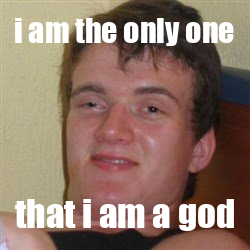

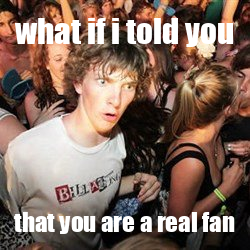

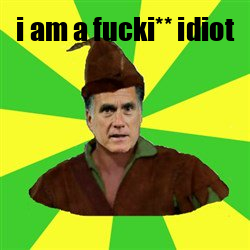

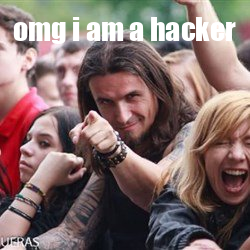

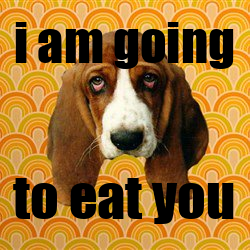

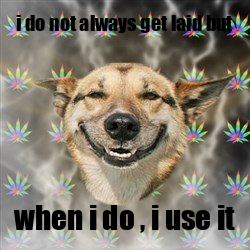

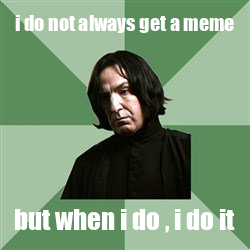

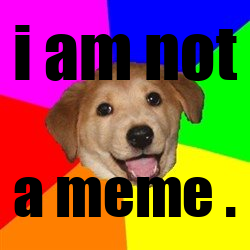

In [116]:
# Read the images for the inference
inference_image_files = os.listdir(os.path.join('./data/' 'jmemes'))

# The image pre-processing will be performed same as it was done during training
img_preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(), # this will convert the image to (C x H x W)
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Initialize the model with the best checkpoint
model_inference = MemeGenerationLSTM.from_pretrained(os.path.join(CHECKPOINTS_DIR, TITLE + '.best.pth')).eval()

for image in inference_image_files:   
   
   # Open the Image and apply preprocessing what we applied during training
   processed_image = img_preprocess(Image.open(os.path.join('./data/jmemes', image)))
   
   with torch.no_grad():
    output = model_inference.cpu().generate(processed_image.unsqueeze(0).cpu(), max_len=25, temperature=1.0, beam_width=10, top_k=10)
    
    for i, out in enumerate(output):
      
       # Display just the first meme generated
       if i == 0:
        # Convert the token indexes to it's corresponding string and remove EOS
        generated_token = [
                    embedding.itos[index.item()]
                    for index in out
                    if index.item() != 0 and index.item() != embedding.stoi[SPECIAL_TOKENS["EOS"]]
                ]
        
        # Check if the token contains profane tokens hide last two characters
        for i, token in enumerate(generated_token):
            if token in profane_tokens:
                generated_token[i] = token[:-2] + '**'

        token_length = len(generated_token)

        if token_length < 6: # If there are only 6 tokens, then it can be accomodated at the top portion of image
            top_meme_portion = ' '.join(generated_token)
            bottom_meme_portion = ''
        else:
            top_meme_portion = ' '.join(generated_token[:token_length//2])
            bottom_meme_portion = ' '.join(generated_token[token_length//2:])
        
        overlay_captions(os.path.join('./data/jmemes', image), top_meme_portion, bottom_meme_portion)       